# Data  Preprocessing
##### Jackson Cornell

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io

from scipy import signal
from scipy.fft import fftshift
from statsmodels.graphics.tsaplots import plot_acf

## Known parameters
----

In [2]:
# sampling rate
fs_lfp = 250
fs_acc = 518

# train and test, choose from total recording count dsplayed below
train_recording_cnt = 8
test_recording_cnt = 3

## Read in raw data
----

In [3]:
# read mat file
data = scipy.io.loadmat(r'C:\Users\jacks\processed_data\ET003M1taskstim.mat')

# clean up data
lfp_data = np.array(data['all']['LFP'][0][0][0])
acc_data = np.array(data['all']['acc'][0][0][0])

# print data info
print("LFP Recording Count:", np.shape(lfp_data)[0])
print("LFP Channel Count:", np.shape(lfp_data[0])[1])
print("LFP Recording Duration:", np.shape(lfp_data[0])[0] / fs_lfp, "s")
print("")
print("Accelerometer Recording Count:", np.shape(acc_data)[0])
print("Accelerometer Channel Count:", np.shape(acc_data[0])[1])
print("Accelerometer Recording Duration:", np.shape(acc_data[0])[0] / fs_acc, "s")

LFP Recording Count: 11
LFP Channel Count: 4
LFP Recording Duration: 334.148 s

Accelerometer Recording Count: 11
Accelerometer Channel Count: 3
Accelerometer Recording Duration: 334.94594594594594 s


## Exploratory data analysis
----

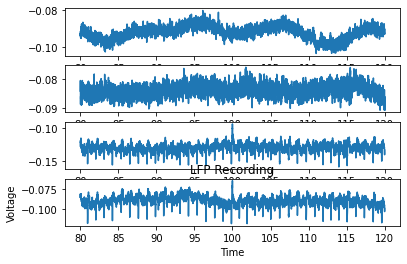

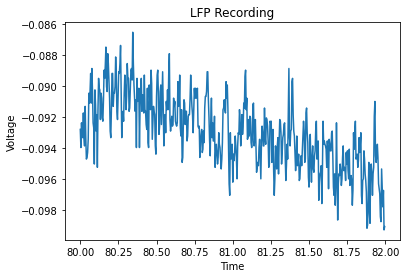

In [4]:
delay = 20000
range1 = 10000
range2 = 500

# Display LFP data
plt.subplot(4, 1, 1)
plt.plot(np.arange(delay, delay+range1) / fs_lfp, lfp_data[0][delay:delay+range1, 0])
plt.subplot(4, 1, 2)
plt.plot(np.arange(delay, delay+range1) / fs_lfp, lfp_data[0][delay:delay+range1, 1])
plt.subplot(4, 1, 3)
plt.plot(np.arange(delay, delay+range1) / fs_lfp, lfp_data[0][delay:delay+range1, 2])
plt.subplot(4, 1, 4)
plt.plot(np.arange(delay, delay+range1) / fs_lfp, lfp_data[0][delay:delay+range1, 3])
plt.title("LFP Recording")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

plt.plot(np.arange(delay, delay+range2) / fs_lfp, lfp_data[0][delay:delay+range2, 0])
plt.title("LFP Recording")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

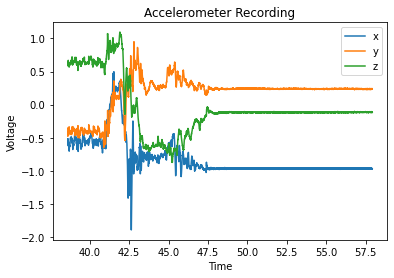

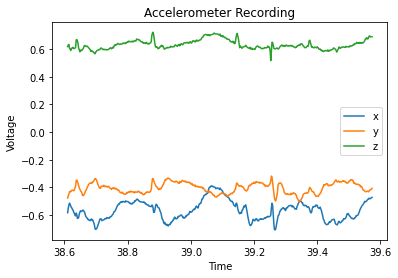

In [5]:
# Display accelerometer data
plt.plot(np.arange(delay, delay+range1) / fs_acc, acc_data[0][delay:delay+range1, 0], label="x")
plt.plot(np.arange(delay, delay+range1) / fs_acc, acc_data[0][delay:delay+range1, 1], label="y")
plt.plot(np.arange(delay, delay+range1) / fs_acc, acc_data[0][delay:delay+range1, 2], label="z")
plt.title("Accelerometer Recording")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.show()

plt.plot(np.arange(delay, delay+range2) / fs_acc, acc_data[0][delay:delay+range2, 0], label="x")
plt.plot(np.arange(delay, delay+range2) / fs_acc, acc_data[0][delay:delay+range2, 1], label="y")
plt.plot(np.arange(delay, delay+range2) / fs_acc, acc_data[0][delay:delay+range2, 2], label="z")
plt.title("Accelerometer Recording")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.show()

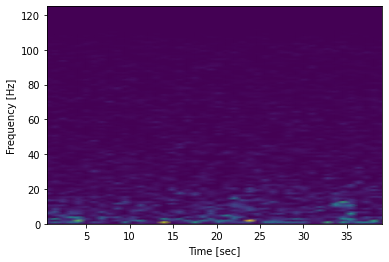

In [6]:
# examine frequency contents of LFP data
f, t, Sxx = signal.spectrogram(lfp_data[0][delay:delay+range1, 1], fs_lfp)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

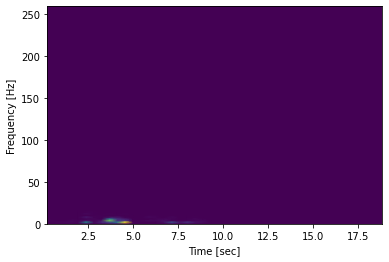

In [7]:
# examine frequency contents of LFP data
f, t, Sxx = signal.spectrogram(acc_data[0][delay:delay+range1, 2], fs_acc)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## Resample accelerometer data to match LFP sample rate
----

Original signal length: 10000
Upsampled signal length: 1250000
Resampled signal length: 4827


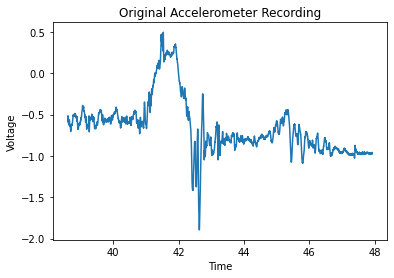

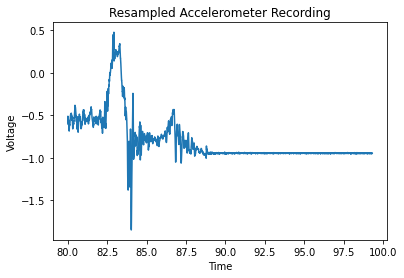

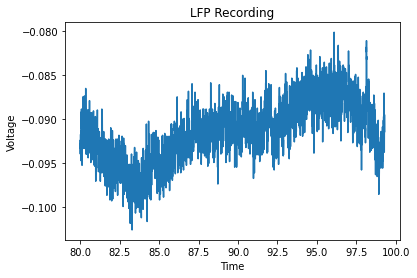

In [8]:
# parameters
upsample_factor = 125
downsample_factor = 259
ds_factor1 = 37
ds_factor2 = 7
assert ds_factor1 * ds_factor2 == downsample_factor

# perform interpolation
upsampled_acc = np.interp(np.linspace(0.0, 1.0, upsample_factor * range1, endpoint=False),
                          np.linspace(0.0, 1.0, range1, endpoint=False),
                          acc_data[0][delay:delay+range1, 0])

# perform decimation
resampled_acc_t = signal.decimate(upsampled_acc, ds_factor1)  # performed twice due to rounding errors
resampled_acc = signal.decimate(resampled_acc_t, ds_factor2)
resampled_length = np.shape(resampled_acc)[0]

# display statistics
print("Original signal length:", np.shape(acc_data[0][delay:delay+range1, 0])[0])
print("Upsampled signal length:", np.shape(upsampled_acc)[0])
print("Resampled signal length:", resampled_length)

# plot results
plt.plot(np.arange(delay, delay+resampled_length) / fs_acc, acc_data[0][delay:delay+resampled_length, 0])
plt.title("Original Accelerometer Recording")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

plt.plot(np.arange(delay, delay+resampled_length) / fs_lfp, resampled_acc)
plt.title("Resampled Accelerometer Recording")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

plt.plot(np.arange(delay, delay+resampled_length) / fs_lfp, lfp_data[0][delay:delay+resampled_length, 0])
plt.title("LFP Recording")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

## Determine optimal window length based off signal statistics
----

Window sized of around 200 ms are common for LFP data. Below, we can see a stationary period of roughly 400 ms.

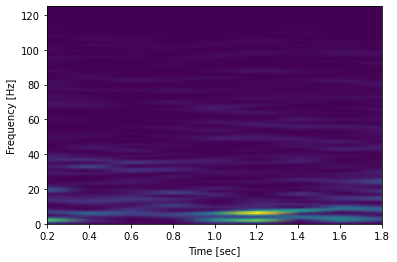

In [9]:
N = int(fs_lfp * 2)
windowed_lfp = lfp_data[0][delay:delay+N, 1]

# examine frequency contents of LFP data
f, t, Sxx = signal.spectrogram(windowed_lfp, fs_lfp,
                               window=('tukey', 0.25),
                               nperseg=100,
                               noverlap=50,
                               nfft=256)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

With the window length above, the ACF is statistically independent at $\tau=16$ for the first recording. We will try and find a maximum lag to apply our kernel embedding to. This seems to be around $\tau=40$.

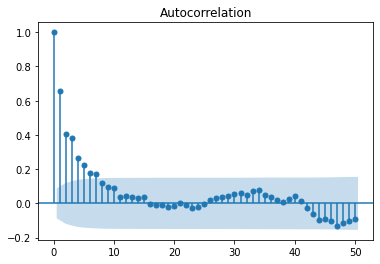

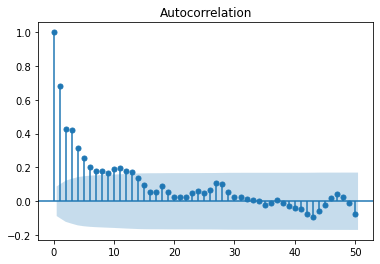

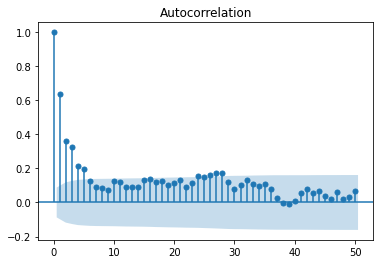

In [10]:
# plot ACF
plot_acf(windowed_lfp, lags=50)
plt.show()

plot_acf(lfp_data[1][delay:delay+N, 1], lags=50)
plt.show()

plot_acf(lfp_data[2][delay:delay+N, 1], lags=50)
plt.show()

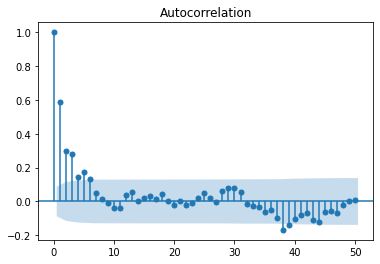

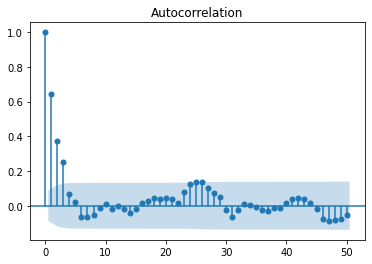

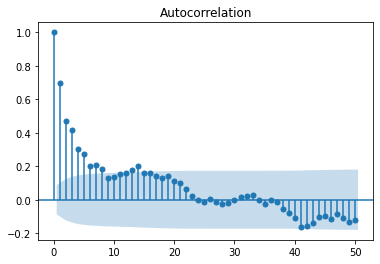

In [11]:
delay = 50000

plot_acf(lfp_data[0][delay:delay+N, 1], lags=50)
plt.show()

plot_acf(lfp_data[1][delay:delay+N, 1], lags=50)
plt.show()

plot_acf(lfp_data[2][delay:delay+N, 1], lags=50)
plt.show()

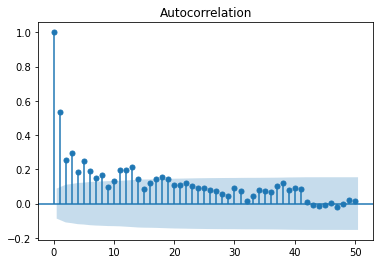

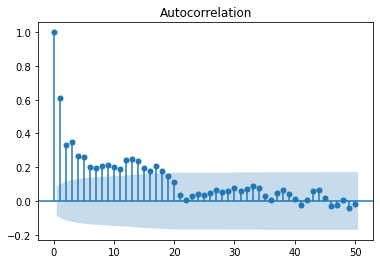

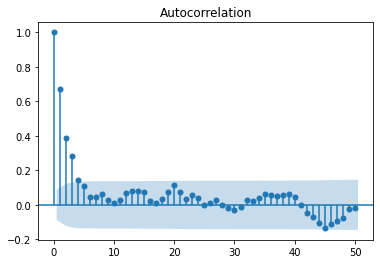

In [12]:
delay = 1000

plot_acf(lfp_data[0][delay:delay+N, 1], lags=50)
plt.show()

plot_acf(lfp_data[1][delay:delay+N, 1], lags=50)
plt.show()

plot_acf(lfp_data[2][delay:delay+N, 1], lags=50)
plt.show()

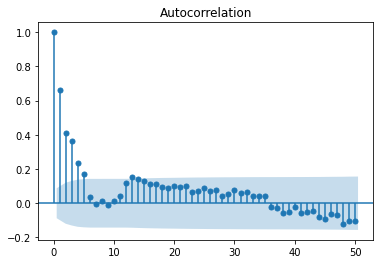

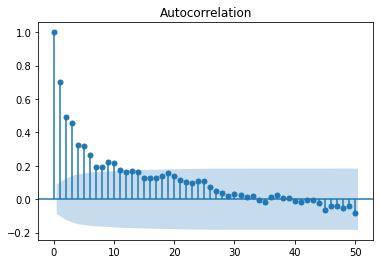

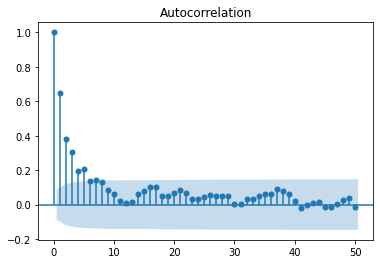

In [13]:
delay = 80000

plot_acf(lfp_data[0][delay:delay+N, 1], lags=50)
plt.show()

plot_acf(lfp_data[1][delay:delay+N, 1], lags=50)
plt.show()

plot_acf(lfp_data[2][delay:delay+N, 1], lags=50)
plt.show()

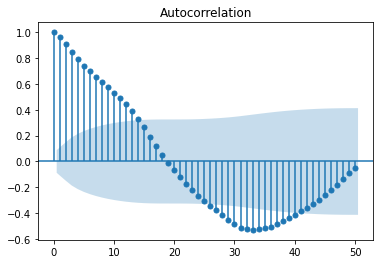

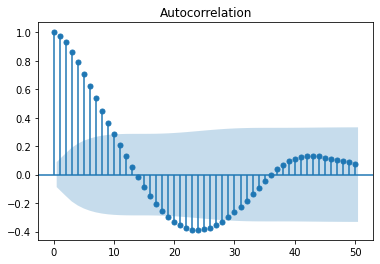

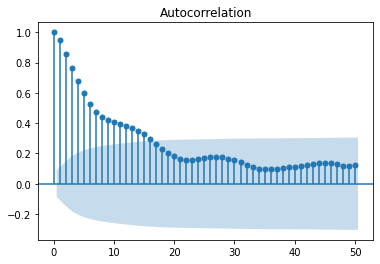

In [14]:
# plot accelerometer
plot_acf(resampled_acc[:N], lags=50)
plt.show()

plot_acf(resampled_acc[1000:1000+N], lags=50)
plt.show()

plot_acf(resampled_acc[2000:2000+N], lags=50)
plt.show()

The accelerometer has a much smoother and more predictable ACF. The LFP datas' ACF is of more importance though for the purpose of windowing. A maximum of $40 \div f_{s_{LFP}} = 160 ms$ and a minimum of $5 \div f_{s_{LFP}} = 20 ms$. A range of these values will act as hyperparameters for the KLMS model.

The windowing for the CNN model is more rigid in its requirements. Window sizes of of between 200 ms and 400 ms are common when processing LFP data. To capture the nonstationary nature of the data, we will apply an FFT for every 40 ms iteration.

## Spectrograms for CNN
---

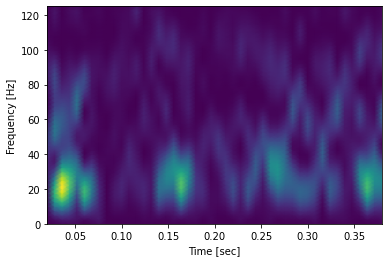

Spectrogram Dimensions: (51, 46)
[[4.68957313e-10 7.59132896e-10 3.15229412e-09 ... 7.10159827e-11
  5.50506764e-10 1.73443440e-09]
 [1.16276833e-09 5.64643900e-09 1.09865471e-08 ... 3.40409696e-09
  2.75645479e-09 4.66390088e-09]
 [1.79411361e-09 1.72450468e-08 2.43404577e-08 ... 1.27255725e-08
  7.54096033e-09 8.19573740e-09]
 ...
 [1.82670859e-10 7.35024347e-09 4.57993648e-10 ... 2.96649950e-09
  7.43765153e-10 3.03475549e-09]
 [1.30757957e-10 7.95525444e-09 3.79136400e-10 ... 1.21011959e-09
  1.93989697e-10 2.99090102e-09]
 [5.77025289e-11 4.07824797e-09 1.73948202e-10 ... 2.94078531e-10
  2.36256280e-12 1.50408672e-09]]


In [15]:
# parameters
window_size = 100
fft_size = 10
overlap = 0.8
windowed_lfp = lfp_data[0][delay:delay+window_size, 1]

# examine frequency contents of LFP data
freq, time, Sxx = signal.spectrogram(windowed_lfp, fs_lfp,
                               nperseg=fft_size,
                               noverlap=int(fft_size * overlap),
                               nfft=window_size)
plt.pcolormesh(time, freq, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

print("Spectrogram Dimensions:", np.shape(Sxx))
print(Sxx)

A window of $400 ms$ will be applied to the LFP data. This window of data will predict the accelerometer data at the end of this segment i.e. if the window is applied from $0-400ms$, the accelerometer data at time $400ms$ will be predicted. Overlapping windows can be applied to reduce the downsample factor of our accelerometer data. For example, if a window is captured every $4ms$, this will line up with our downsamledd accelerometer data with $f_{s_{LFP}}=250 Hz$. This will produce too many samples to train our model with, so we will opt for a larger sampling period and again downsample our accelerometer data. We will instead have an overlap of $200ms$, or an overlap factor of 2. This will have the added benefit of getting rid of higher frequency contents i.e. noise in the accelerometer data.

In addition, we will need to process all 4 channels of our LFP data to estimate the accelerometer data. To achieve this, we will construct the spectrogram "images" into a (51, 46, 4) dimension tensor that will act as the input to our CNN model. The output to the CNN model will be a (3,) vector that will represent the x-y-z accelerometer signals at that instance of time.

## Apply moving average (MA) filter to accelerometer data
----

In [16]:
# parameters
fs_new = 5  # 1 sample / 200 ms
downsample_factor = int(fs_lfp / fs_new)

print("Downsample factor:", int(downsample_factor))

Downsample factor: 50


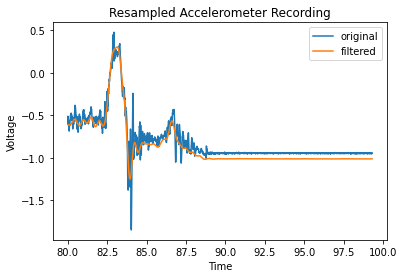

In [17]:
# FIR filter design
b = [-0.00522976969654727,
  -0.000560433515183372,
  -0.0005879046685356189,
  -0.0006144098787837698,
  -0.0006398258232683617,
  -0.0006639488421795402,
  -0.000686701060494037,
  -0.0007078690575819224,
  -0.00072734046615764,
  -0.0007450124223546479,
  -0.0007607497282814199,
  -0.000774361286844492,
  -0.0007856896266741399,
  -0.0007945797718139921,
  -0.0008008960134012433,
  -0.0008045490536507538,
  -0.000805463471141381,
  -0.0008035202546359405,
  -0.0007985615438343808,
  -0.0007904512052608203,
  -0.0007790945975853025,
  -0.0007645079195236311,
  -0.0007466898038610989,
  -0.0007255005464266609,
  -0.0007006666256202271,
  -0.0006723205122973175,
  -0.0006406380978287092,
  -0.0006055809364516472,
  -0.00056641969033693,
  -0.0005245233867090431,
  -0.0004786983666658729,
  -0.00042963366025958297,
  -0.0003772605108028464,
  -0.0003217254816247227,
  -0.00026302308003315977,
  -0.00020137007261899283,
  -0.0001369112524187922,
  -0.0000697582046867073,
  -6.653947450723948e-8,
  0.0000719192694666781,
  0.00014599342539527496,
  0.0002219771203020964,
  0.00029967700833921564,
  0.000378859591784035,
  0.00045925514581032556,
  0.0005405913923955102,
  0.0006226279819153048,
  0.000705133391619707,
  0.0007877892564508873,
  0.000870277161388022,
  0.0009523062265110934,
  0.0010335812596497876,
  0.0011136535615135132,
  0.0011922622867316381,
  0.0012689533594025912,
  0.0013438495160740201,
  0.0014152538149068907,
  0.0014847808529905682,
  0.0015504341864223043,
  0.0016122740460248236,
  0.0016703844602498261,
  0.001724430461265395,
  0.0017737716914853546,
  0.0018181526152067746,
  0.0018574658246454238,
  0.0018915648182749381,
  0.0019201692891223678,
  0.0019429540381374617,
  0.0019595712367353837,
  0.001969728013003854,
  0.001973174755416274,
  0.001969649816541209,
  0.0019588793495544936,
  0.0019406314141150864,
  0.0019147598332715644,
  0.0018812440215329833,
  0.0018402895419123925,
  0.0017922303635599021,
  0.0017373750571295728,
  0.0016757442148791937,
  0.0016068876674971424,
  0.0015293377917096392,
  0.0014411535605955985,
  0.001342362316285495,
  0.0012525215938752991,
  0.0011409211983264451,
  0.0010277029216358565,
  0.0009074587212922,
  0.0007809730726638415,
  0.0006485398152999211,
  0.0005105933234803262,
  0.00036742639375998037,
  0.00021940158417361813,
  0.0000669548620298512,
  -0.00008942563762639262,
  -0.00024926544185230575,
  -0.0004120377757146344,
  -0.0005772089443642813,
  -0.0007442590091905181,
  -0.0009126354429600253,
  -0.0010817169459567918,
  -0.0012508436698857252,
  -0.0014193672760023062,
  -0.0015866631951609983,
  -0.001752154318434934,
  -0.0019151565029332264,
  -0.0020748646796718124,
  -0.002230489310025245,
  -0.002381540094072683,
  -0.002527287833663975,
  -0.00266690017435714,
  -0.0027993865980285577,
  -0.0029249547460977313,
  -0.003041697039306195,
  -0.0031497874675384518,
  -0.00324825236398359,
  -0.003336449486802089,
  -0.003413656818301452,
  -0.003479385699232179,
  -0.003532953533382869,
  -0.003573702686940722,
  -0.003601080940219207,
  -0.0036146038616615824,
  -0.003613721268072974,
  -0.003597892718574346,
  -0.003566632302888172,
  -0.003519525566908044,
  -0.00345621373796425,
  -0.0033763542168496075,
  -0.0032796081258571557,
  -0.003165691817130507,
  -0.0030344279733142783,
  -0.002885642872277675,
  -0.0027192001295324353,
  -0.0025350358230754695,
  -0.0023331829374547775,
  -0.00211352970399029,
  -0.0018761957153400509,
  -0.0016209640030349812,
  -0.0013492945649294067,
  -0.0010585067913991312,
  -0.0007524231429819083,
  -0.0004292970702961897,
  -0.0000892473562811366,
  0.00026671048293896185,
  0.0006376813242390007,
  0.0010233719189827117,
  0.0014234342677589221,
  0.0018373207087292727,
  0.0022642922016364252,
  0.0027035648624877343,
  0.0031543572306565655,
  0.003615966140281129,
  0.004087683851145636,
  0.004568697950419642,
  0.005058066423553038,
  0.005554741092409959,
  0.006057613317214209,
  0.0065656141229951245,
  0.007077836035071489,
  0.007593449769673476,
  0.008111607456162538,
  0.008631240834625018,
  0.009150952454600968,
  0.009668948623076993,
  0.010184084354358074,
  0.01069660143733805,
  0.011207367787045883,
  0.011708093823712695,
  0.012205096804603435,
  0.012693362997581694,
  0.013172878963222513,
  0.013642441780895263,
  0.01410106750832395,
  0.014547598785280282,
  0.01498101647815172,
  0.015400338031201282,
  0.015804588264146748,
  0.01619279264012354,
  0.016564054820840564,
  0.016917482329548313,
  0.01725219847146682,
  0.017567402022023854,
  0.01786238083860661,
  0.01813647125115341,
  0.01838902356524701,
  0.01861940141435486,
  0.018826999987647308,
  0.01901137598703197,
  0.019172162740592583,
  0.019308947017529412,
  0.01942123072843263,
  0.019508866141593598,
  0.01957166075207318,
  0.019609519394438325,
  0.01962179475977161,
  0.019609519394438325,
  0.01957166075207318,
  0.019508866141593598,
  0.01942123072843263,
  0.019308947017529412,
  0.019172162740592583,
  0.01901137598703197,
  0.018826999987647308,
  0.01861940141435486,
  0.01838902356524701,
  0.01813647125115341,
  0.01786238083860661,
  0.017567402022023854,
  0.01725219847146682,
  0.016917482329548313,
  0.016564054820840564,
  0.01619279264012354,
  0.015804588264146748,
  0.015400338031201282,
  0.01498101647815172,
  0.014547598785280282,
  0.01410106750832395,
  0.013642441780895263,
  0.013172878963222513,
  0.012693362997581694,
  0.012205096804603435,
  0.011708093823712695,
  0.011207367787045883,
  0.01069660143733805,
  0.010184084354358074,
  0.009668948623076993,
  0.009150952454600968,
  0.008631240834625018,
  0.008111607456162538,
  0.007593449769673476,
  0.007077836035071489,
  0.0065656141229951245,
  0.006057613317214209,
  0.005554741092409959,
  0.005058066423553038,
  0.004568697950419642,
  0.004087683851145636,
  0.003615966140281129,
  0.0031543572306565655,
  0.0027035648624877343,
  0.0022642922016364252,
  0.0018373207087292727,
  0.0014234342677589221,
  0.0010233719189827117,
  0.0006376813242390007,
  0.00026671048293896185,
  -0.0000892473562811366,
  -0.0004292970702961897,
  -0.0007524231429819083,
  -0.0010585067913991312,
  -0.0013492945649294067,
  -0.0016209640030349812,
  -0.0018761957153400509,
  -0.00211352970399029,
  -0.0023331829374547775,
  -0.0025350358230754695,
  -0.0027192001295324353,
  -0.002885642872277675,
  -0.0030344279733142783,
  -0.003165691817130507,
  -0.0032796081258571557,
  -0.0033763542168496075,
  -0.00345621373796425,
  -0.003519525566908044,
  -0.003566632302888172,
  -0.003597892718574346,
  -0.003613721268072974,
  -0.0036146038616615824,
  -0.003601080940219207,
  -0.003573702686940722,
  -0.003532953533382869,
  -0.003479385699232179,
  -0.003413656818301452,
  -0.003336449486802089,
  -0.00324825236398359,
  -0.0031497874675384518,
  -0.003041697039306195,
  -0.0029249547460977313,
  -0.0027993865980285577,
  -0.00266690017435714,
  -0.002527287833663975,
  -0.002381540094072683,
  -0.002230489310025245,
  -0.0020748646796718124,
  -0.0019151565029332264,
  -0.001752154318434934,
  -0.0015866631951609983,
  -0.0014193672760023062,
  -0.0012508436698857252,
  -0.0010817169459567918,
  -0.0009126354429600253,
  -0.0007442590091905181,
  -0.0005772089443642813,
  -0.0004120377757146344,
  -0.00024926544185230575,
  -0.00008942563762639262,
  0.0000669548620298512,
  0.00021940158417361813,
  0.00036742639375998037,
  0.0005105933234803262,
  0.0006485398152999211,
  0.0007809730726638415,
  0.0009074587212922,
  0.0010277029216358565,
  0.0011409211983264451,
  0.0012525215938752991,
  0.001342362316285495,
  0.0014411535605955985,
  0.0015293377917096392,
  0.0016068876674971424,
  0.0016757442148791937,
  0.0017373750571295728,
  0.0017922303635599021,
  0.0018402895419123925,
  0.0018812440215329833,
  0.0019147598332715644,
  0.0019406314141150864,
  0.0019588793495544936,
  0.001969649816541209,
  0.001973174755416274,
  0.001969728013003854,
  0.0019595712367353837,
  0.0019429540381374617,
  0.0019201692891223678,
  0.0018915648182749381,
  0.0018574658246454238,
  0.0018181526152067746,
  0.0017737716914853546,
  0.001724430461265395,
  0.0016703844602498261,
  0.0016122740460248236,
  0.0015504341864223043,
  0.0014847808529905682,
  0.0014152538149068907,
  0.0013438495160740201,
  0.0012689533594025912,
  0.0011922622867316381,
  0.0011136535615135132,
  0.0010335812596497876,
  0.0009523062265110934,
  0.000870277161388022,
  0.0007877892564508873,
  0.000705133391619707,
  0.0006226279819153048,
  0.0005405913923955102,
  0.00045925514581032556,
  0.000378859591784035,
  0.00029967700833921564,
  0.0002219771203020964,
  0.00014599342539527496,
  0.0000719192694666781,
  -6.653947450723948e-8,
  -0.0000697582046867073,
  -0.0001369112524187922,
  -0.00020137007261899283,
  -0.00026302308003315977,
  -0.0003217254816247227,
  -0.0003772605108028464,
  -0.00042963366025958297,
  -0.0004786983666658729,
  -0.0005245233867090431,
  -0.00056641969033693,
  -0.0006055809364516472,
  -0.0006406380978287092,
  -0.0006723205122973175,
  -0.0007006666256202271,
  -0.0007255005464266609,
  -0.0007466898038610989,
  -0.0007645079195236311,
  -0.0007790945975853025,
  -0.0007904512052608203,
  -0.0007985615438343808,
  -0.0008035202546359405,
  -0.000805463471141381,
  -0.0008045490536507538,
  -0.0008008960134012433,
  -0.0007945797718139921,
  -0.0007856896266741399,
  -0.000774361286844492,
  -0.0007607497282814199,
  -0.0007450124223546479,
  -0.00072734046615764,
  -0.0007078690575819224,
  -0.000686701060494037,
  -0.0006639488421795402,
  -0.0006398258232683617,
  -0.0006144098787837698,
  -0.0005879046685356189,
  -0.000560433515183372,
  -0.00522976969654727]
a = [1]

# filter signal
filtered_acc = signal.filtfilt(b, a, resampled_acc)

# display results
delay = 20000
plt.plot(np.arange(delay, delay+resampled_length) / fs_lfp, resampled_acc, label="original")
plt.plot(np.arange(delay, delay+resampled_length) / fs_lfp, filtered_acc, label='filtered')
plt.title("Resampled Accelerometer Recording")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.show()

Original signal length: 4827
Resampled signal length: 97


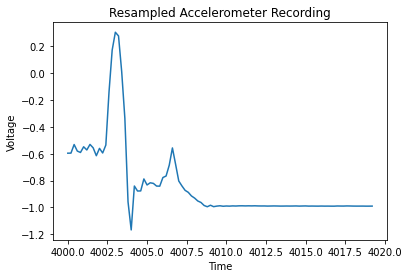

In [18]:
# apply downsampling that will be used for CNN training
ds_factor1 = 10
ds_factor2 = 5

resampled_acc_t = signal.decimate(filtered_acc, ds_factor1)  # performed twice due to rounding errors
resampled_acc = signal.decimate(resampled_acc_t, ds_factor2)
resampled_length = np.shape(resampled_acc)[0]

# display results
print("Original signal length:", np.shape(filtered_acc)[0])
print("Resampled signal length:", resampled_length)

# plot results
plt.plot(np.arange(delay, delay+resampled_length) / fs_new, resampled_acc)
plt.title("Resampled Accelerometer Recording")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

## Preprocess all data and write to files
----

In [19]:
# parameters
recording_cnt = np.shape(acc_data)[0]
acc_ch_cnt = 3
lfp_ch_cnt = 4     

#### Resample accelerometer data for KLMS and CNN

In [20]:
# parameters
resampled_acc = []
upsample_factor = 125
downsample_factor = 259
ds_factor1 = 37
ds_factor2 = 7
assert ds_factor1 * ds_factor2 == downsample_factor

# resample accelerometer data
for i in range(recording_cnt) :
    channel_data = []
    for j in range(acc_ch_cnt) :
        # interpolation
        data_length = np.shape(acc_data[i])[0]
        upsampled_acc = np.interp(np.linspace(0.0, 1.0, upsample_factor * data_length, endpoint=False),
                                  np.linspace(0.0, 1.0, data_length, endpoint=False),
                                  acc_data[i][:, j])
        # decimation
        resampled_acc_t1 = signal.decimate(upsampled_acc, ds_factor1)  # performed twice due to rounding errors
        resampled_acc_t2 = signal.decimate(resampled_acc_t1, ds_factor2)
        # save channel data
        channel_data.append(resampled_acc_t2)
    # save recording data
    resampled_acc.append(channel_data.copy())

In [21]:
# display info
print("Acc. (Recordings, Channels, Samples):", np.shape(resampled_acc), np.shape(resampled_acc[0][0])[0])

Acc. (Recordings, Channels, Samples): (11, 3) 83737


C:\Users\jacks\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


#### Apply filtering and second downsampling

In [22]:
# parameters
filtered_acc = []
downsampled_acc = []
filter_delay = int(len(b) / 2)
ds_factor1 = 10
ds_factor2 = 5
front_append = 1  # to line up with spectrogram data

# filter and downsample data
for i in range(recording_cnt) :
    channel_data_fl = []
    channel_data_ds = []
    for j in range(acc_ch_cnt) :
        # filter signal
        filtered_acc_t = signal.filtfilt(b, a, resampled_acc[i][j])
        # decimation
        resampled_acc_t1 = signal.decimate(filtered_acc_t, ds_factor1)  # performed twice due to rounding errors
        resampled_acc_t2 = signal.decimate(resampled_acc_t1, ds_factor2)
        # save channel data
        channel_data_fl.append(filtered_acc_t)
        channel_data_ds.append(resampled_acc_t2[1:])
    # save recording data
    filtered_acc.append(channel_data_fl.copy())
    downsampled_acc.append(channel_data_ds.copy())

In [23]:
# display info
print("Acc. (Recordings, Channels, Sampeles):", np.shape(filtered_acc), np.shape(filtered_acc[0][0])[0])
print("Acc. (Recordings, Channels, Sampeles):", np.shape(downsampled_acc), np.shape(downsampled_acc[0][0])[0])

Acc. (Recordings, Channels, Sampeles): (11, 3) 83737
Acc. (Recordings, Channels, Sampeles): (11, 3) 1674


#### Apply spectogram for CNN data

In [24]:
# parameters
spect_lfp = []
window_size = 100
fft_size = 10
overlap = 0.8
offset_iter = 50

# calculate expected window size
_, _, Sxx = signal.spectrogram(lfp_data[i][:window_size, 0],
                               fs_lfp,
                               nperseg=fft_size,
                               noverlap=int(fft_size * overlap),
                               nfft=window_size)
expected_img_size = np.shape(Sxx)

# convert to spectrogram "images"
for i in range(recording_cnt) :
    channel_data = []
    offset = 0
    window_cnt = int(len(lfp_data[i][:, 0]) / (window_size / 2)) - 1
    for k in range(window_cnt) :
        tensor_t = np.zeros((expected_img_size[0], expected_img_size[1], lfp_ch_cnt))
        for j in range(lfp_ch_cnt) :
            # window data
            data_window = lfp_data[i][offset:(offset+window_size), j]
            # apply spectrogram
            _, _, Sxx = signal.spectrogram(data_window, fs_lfp,
                                           nperseg=fft_size,
                                           noverlap=int(fft_size * overlap),
                                           nfft=window_size)
            tensor_t[:, :, j] = Sxx
        # append tensor
        channel_data.append(tensor_t)
        # iterate window offset
        offset += offset_iter
    # save recording data
    spect_lfp.append(channel_data.copy())

In [25]:
# display info
print("LFP (Recordings, Windows, Frequencies, Times, Channels):",
      np.shape(spect_lfp)[0], np.shape(spect_lfp[0]))
print("LFP (Recordings, Samples, Channels):",
      np.shape(lfp_data)[0], np.shape(lfp_data[0]))

LFP (Recordings, Windows, Frequencies, Times, Channels): 11 (1669, 51, 46, 4)
LFP (Recordings, Samples, Channels): 11 (83537, 4)


#### Divide into training and test set

In [26]:
# randomly choose recordings to go into train and test
indices = np.random.permutation(recording_cnt)

# split data
lfp_train = np.array(lfp_data[indices[:train_recording_cnt]])
lfp_test = np.array(lfp_data[indices[-test_recording_cnt:]])

spect_train = np.array([spect_lfp[i] for i in indices[:train_recording_cnt]])
spect_test = np.array([spect_lfp[i] for i in indices[-test_recording_cnt:]])

normal_acc_train = np.array([filtered_acc[i][:] for i in indices[:train_recording_cnt]])
normal_acc_test = np.array([filtered_acc[i][:] for i in indices[-test_recording_cnt:]])

downsampled_acc_train = np.array([downsampled_acc[i][:] for i in indices[:train_recording_cnt]])
downsampled_acc_test = np.array([downsampled_acc[i][:] for i in indices[-test_recording_cnt:]])

<ipython-input-26-6899f1b11f22>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spect_train = np.array([spect_lfp[i] for i in indices[:train_recording_cnt]])
<ipython-input-26-6899f1b11f22>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spect_test = np.array([spect_lfp[i] for i in indices[-test_recording_cnt:]])
<ipython-input-26-6899f1b11f22>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do th

#### Write out data

In [27]:
with open('../data/lfp_train.npy', 'wb') as f:
    np.save(f, lfp_train, allow_pickle=True)
    
with open('../data/lfp_test.npy', 'wb') as f:
    np.save(f, lfp_test, allow_pickle=True)
    
with open('../data/spect_train.npy', 'wb') as f:
    np.save(f, spect_train, allow_pickle=True)
    
with open('../data/spect_test.npy', 'wb') as f:
    np.save(f, spect_test, allow_pickle=True)
    
with open('../data/normal_acc_train.npy', 'wb') as f:
    np.save(f, normal_acc_train, allow_pickle=True)
    
with open('../data/normal_acc_test.npy', 'wb') as f:
    np.save(f, normal_acc_test, allow_pickle=True)
    
with open('../data/downsampled_acc_train.npy', 'wb') as f:
    np.save(f, downsampled_acc_train, allow_pickle=True)
    
with open('../data/downsampled_acc_test.npy', 'wb') as f:
    np.save(f, downsampled_acc_test, allow_pickle=True)

print("Files written!")

Files written!


#### Demonstrate file read

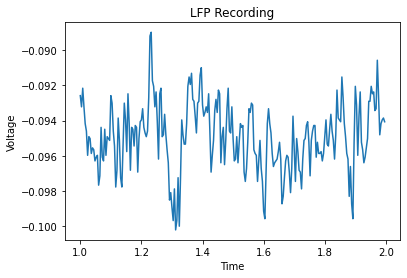

In [28]:
# open file
lfp_train = np.load('../data/lfp_train.npy', allow_pickle=True)

# format data
N = int(fs_lfp)  # 1.0 seconds
data = lfp_train[0][N:2*N, 0]

# display contents
plt.plot(np.arange(N, 2*N) / fs_lfp, data)
plt.title("LFP Recording")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

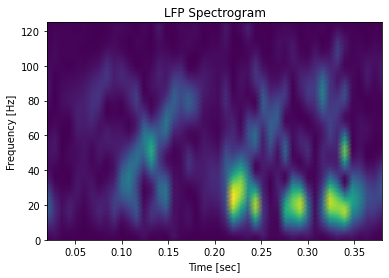

In [29]:
# open file
spect_train = np.load('../data/spect_train.npy', allow_pickle=True)

# format data
data = spect_train[0][5][:, :, 0]

# display contents
plt.pcolormesh(time, freq, data, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('LFP Spectrogram')
plt.show()

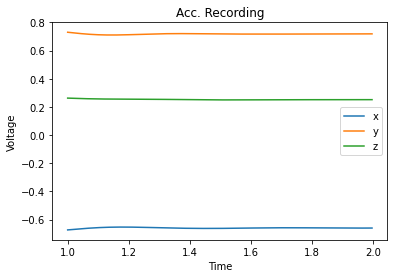

In [30]:
# open file
n_acc_train = np.load('../data/normal_acc_train.npy', allow_pickle=True)

# format data
N = int(fs_lfp)  # 1.0 seconds
data_x = n_acc_train[0][0][N:2*N]
data_y = n_acc_train[0][1][N:2*N]
data_z = n_acc_train[0][2][N:2*N]

# display contents
plt.plot(np.arange(N, 2*N) / fs_lfp, data_x, label='x')
plt.plot(np.arange(N, 2*N) / fs_lfp, data_y, label='y')
plt.plot(np.arange(N, 2*N) / fs_lfp, data_z, label='z')
plt.title("Acc. Recording")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.show()

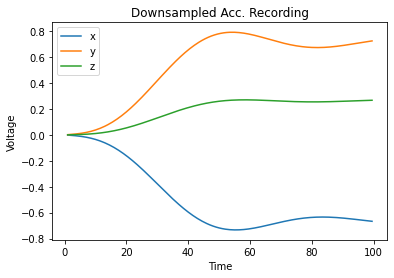

In [31]:
# open file
ds_acc_train = np.load('../data/downsampled_acc_train.npy', allow_pickle=True)

# format data
fs_ds = 2
N = int(fs_ds)  # 1.0 seconds
data_x = n_acc_train[0][0][N:100*N]
data_y = n_acc_train[0][1][N:100*N]
data_z = n_acc_train[0][2][N:100*N]

# display contents
plt.plot(np.arange(N, 100*N) / fs_ds, data_x, label='x')
plt.plot(np.arange(N, 100*N) / fs_ds, data_y, label='y')
plt.plot(np.arange(N, 100*N) / fs_ds, data_z, label='z')
plt.title("Downsampled Acc. Recording")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.show()